<a href="https://colab.research.google.com/github/himasai97/GANs/blob/main/DCGAN/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the neccessary libraries


In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # set for testing purposes

def tensor_image_viz(tensor_img, num_images=25, size=(1,28,28)):
  '''
  To visualize images
  Parameters: a tensor of images, number of images and size per image
  Output: prints the images in a uniform grid
  '''
  tensor_img = (tensor_img + 1) / 2
  image_unflat = tensor_img.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1,2,0).squeeze())
  plt.show() 

# Generator

In [2]:
class Generator(nn.Module):
  '''
  Generator Class with values:
    noise_dim: the dimension of the noise vector, a scalar
    img_chan: the number of channels used to represent the output image, a scalr
    hidden_dim: the initial hidden layer output dimension, a scalar
  '''
  def __init__(self, noise_dim=10, img_chan=1, hidden_dim=64):
    super(Generator, self).__init__()
    self.noise_dim = noise_dim
    # building the neural network
    self.gen = nn.Sequential(
        self.get_gen_block(noise_dim, hidden_dim*4),
        self.get_gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
        self.get_gen_block(hidden_dim*2, hidden_dim),
        self.get_gen_block(hidden_dim, img_chan, kernel_size=4, final_layer=True),
      )
    
  def get_gen_block(self, in_chan, out_chan, kernel_size=3, stride=2, final_layer=False):
    '''
    To create a block of generator's neural netowrk
    Parameters:
          in_chan: number of channels that the input feature for that layer has, a scalar
          out_chan: number of channels that the input feature for that layer should have, a scalar
          kernel_size: to determine the size of each convolution filter, equivalent to (kernel_size, kernel_size)
          stride: the amount by which the kernel is shifted when sliding across the input feature
          final_layer: a boolean indicating whether the given layer is the final layer (value is true in that case and false otherwise)
    Returns:
          a generator neural network layer consisting of:
            Transposed Convolution layer
            Batch Normalization (for stabilization)
            ReLU (a non linear transformation to transform the output)
          if final_layer:
            Transposed Convolution layer
            Tanh activation  
    '''

    # building the neural block
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride),
          nn.BatchNorm2d(out_chan),
          nn.ReLU(inplace=True)
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride),
          nn.Tanh()
      )

  def unsqueeze_noise(self, noise):
    '''
    to reshape the noise vector for completing a forward pass of the generator
    Parameters:
          noise: a tensor with (n_samples, noise_dim) dimension
    Returns:
          a copy of that noise with width and height = 1 and channels = noise_dim
    '''
    return noise.view(len(noise), self.noise_dim, 1, 1)

  def forward(self, noise):
    '''
    to complete a forward pass of the generator 
    Parameters:
        noise: a tensor with dimensions (n_samples, noise_dim)
    Returns:
        a batch of generated images
    '''
    x = self.unsqueeze_noise(noise)
    return self.gen(x)

def get_noise(n_samples, noise_dim, device='cpu'):
  '''
  For creating noise vectors
  Parameters:
        n_samples: the number of samples to generate, a scalar
        noise_dim: the dimension of the noise vector, a scalar
        device: the device type
  Returns:
        a tensor filled with random numbers of (n_samples, noise_dim) dimension
  '''
  return torch.randn(n_samples, noise_dim, device=device)

# Discriminator

In [3]:
class Discriminator(nn.Module):
  '''
  Discriminator Class with values:
    img_chan: the number of channels used to represent the output image, a scalr
              (MNIST is black-and-white, so number of channels in this case is 1)
    hidden_dim: the initial hidden layer output dimension, a scalar
  '''
  def __init__(self, img_chan=1, hidden_dim=16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.get_disc_block(img_chan, hidden_dim),
        self.get_disc_block(hidden_dim, hidden_dim*2),
        self.get_disc_block(hidden_dim*2, 1, final_layer=True),
    )

  def get_disc_block(self, in_chan, out_chan, kernel_size=4, stride=2, final_layer=False):
    '''
    To create a block of discriminator's neural netowrk
    Parameters:
          in_chan: number of channels that the input feature for that layer has, a scalar
          out_chan: number of channels that the input feature for that layer should have, a scalar
          kernel_size: to determine the size of each convolution filter, equivalent to (kernel_size, kernel_size)
          stride: the amount by which the kernel is shifted when sliding across the input feature
          final_layer: a boolean indicating whether the given layer is the final layer (value is true in that case and false otherwise)
    Returns:
          a discriminator neural network layer consisting of:
            Convolution layer
            Batch Normalization (for stabilization)
            Leaky ReLU with the slope of the leak set to 0.2
          if final_layer:
            Convolution layer
    '''
    # building the neural block
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(in_chan, out_chan, kernel_size, stride),
          nn.BatchNorm2d(out_chan),
          nn.LeakyReLU(0.2, inplace=True)
      )
    else:
      return nn.Sequential(
          nn.Conv2d(in_chan, out_chan, kernel_size, stride)
      )
  
  def forward(self, image):
    '''
    To complete a forward pass of the discriminator
    Parameters:
          image: a flattened image tensor with im_dim dimension
    Returns:
          a 1-D tensor indicating whether the image is fake/real
    '''
    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred), -1)



# Training

In [4]:
# Set the parameters
criterion = nn.BCEWithLogitsLoss() # the loss function
noise_dim = 64 # the dimension of the noise vector
viz_step = 500 # how often to display/visualize the images
batch_size = 128 # the number of images per forward/backward pass
lr = 0.0002 # the learning rate

# Parameters for controlling the optimizer's momentum
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# Transform the image values to be between -1 and 1, the range of the tanh activation
transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,)),
            ])

# Load the data
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

In [5]:
gen = Generator(noise_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
  '''
  To initialize the weights by sampling values from the normal distribution
  with mean 0 and standard deviation 0.02
  '''
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Step 500: Generator loss: 0.9081949452161792, Discriminator loss: 0.500825244754553


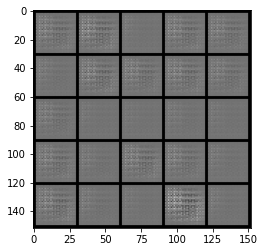

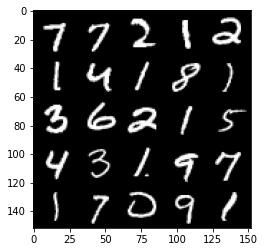

Step 1000: Generator loss: 2.4369788227081286, Discriminator loss: 0.12875624680519124


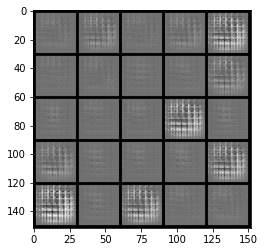

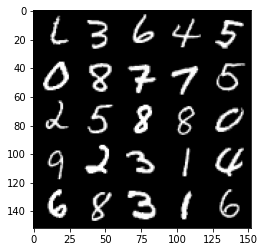

Step 1500: Generator loss: 2.3056813533306113, Discriminator loss: 0.2688362461775542


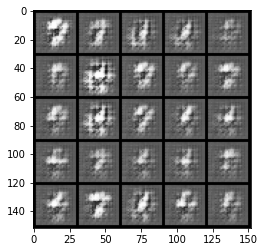

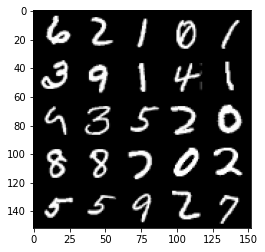

Step 2000: Generator loss: 1.6889581892788417, Discriminator loss: 0.3789643316864968


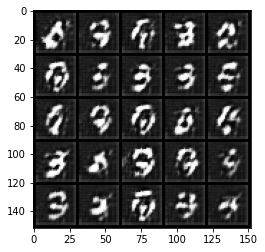

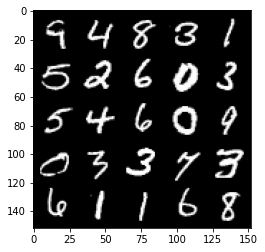

Step 2500: Generator loss: 1.1499719424247739, Discriminator loss: 0.5095969191789624


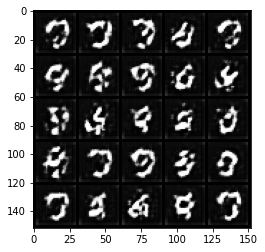

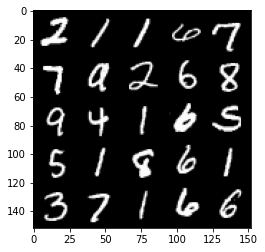

Step 3000: Generator loss: 1.0079240758419035, Discriminator loss: 0.5518825801014899


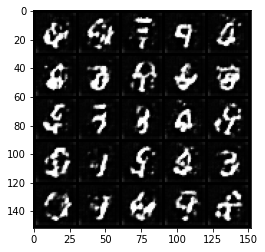

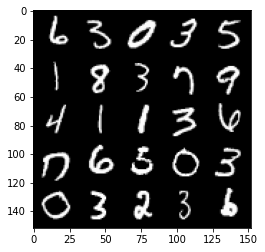

Step 3500: Generator loss: 0.9406833723187449, Discriminator loss: 0.5778021790981296


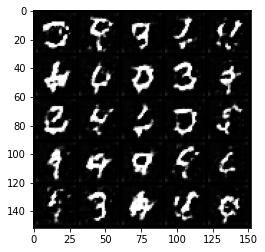

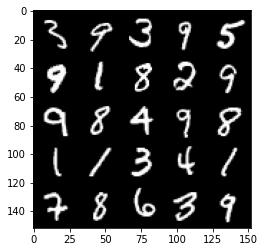

Step 4000: Generator loss: 0.8851500019431113, Discriminator loss: 0.6050335720777511


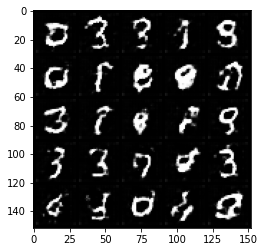

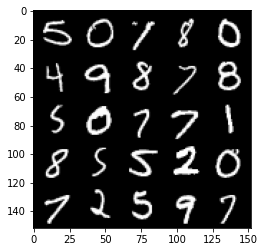

Step 4500: Generator loss: 0.871156622886657, Discriminator loss: 0.6171636762619012


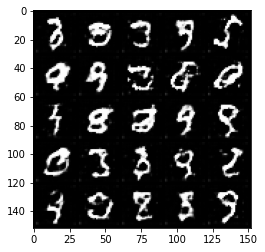

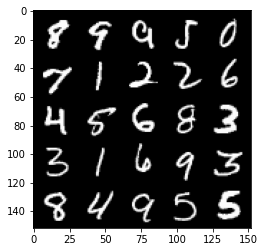

Step 5000: Generator loss: 0.8726383547186856, Discriminator loss: 0.6175197148323056


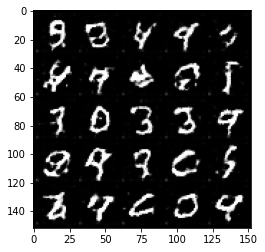

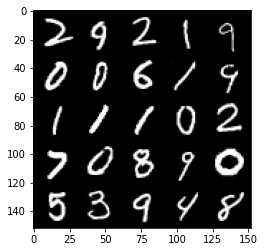

Step 5500: Generator loss: 0.8617761463522913, Discriminator loss: 0.6276580634117133


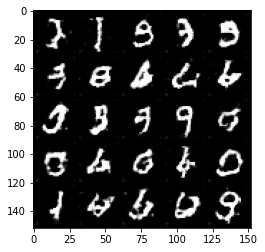

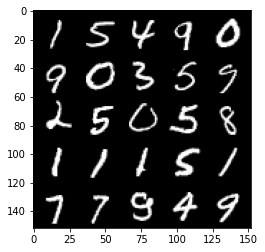

Step 6000: Generator loss: 0.847233810842037, Discriminator loss: 0.6323960300683978


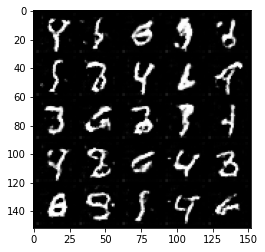

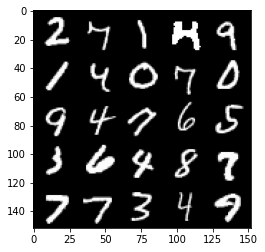

Step 6500: Generator loss: 0.8326322857737546, Discriminator loss: 0.6415366846323012


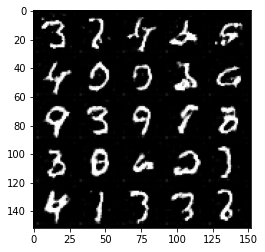

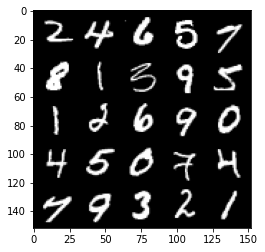

Step 7000: Generator loss: 0.8283358522653576, Discriminator loss: 0.6473880394697186


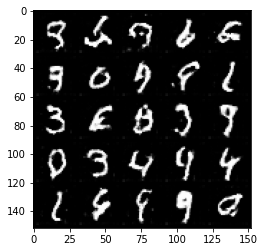

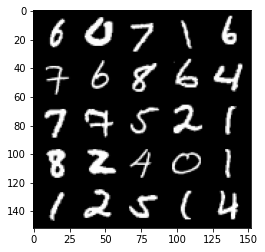

Step 7500: Generator loss: 0.8163640695810317, Discriminator loss: 0.6520060660839078


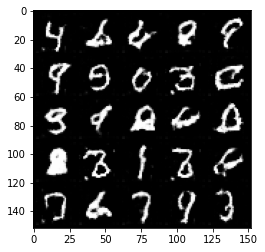

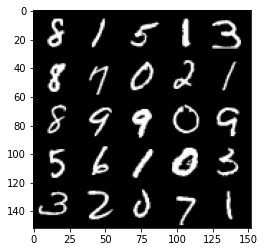

Step 8000: Generator loss: 0.7963592290282255, Discriminator loss: 0.6607140324115751


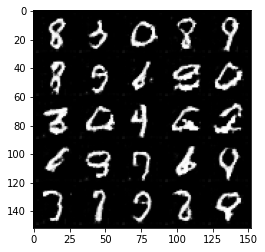

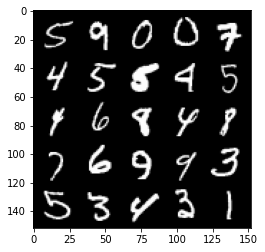

Step 8500: Generator loss: 0.79561683022976, Discriminator loss: 0.6661328623294829


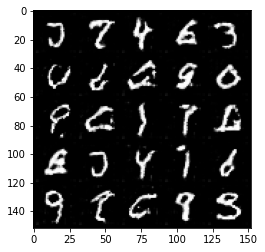

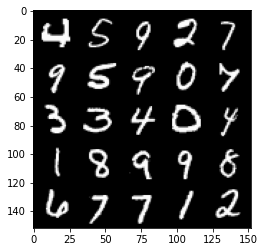

Step 9000: Generator loss: 0.7817769857645042, Discriminator loss: 0.6723012439012523


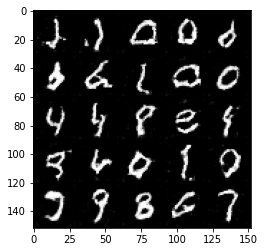

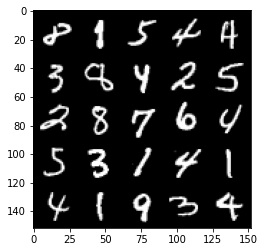

Step 9500: Generator loss: 0.7703260948061945, Discriminator loss: 0.6788579072952264


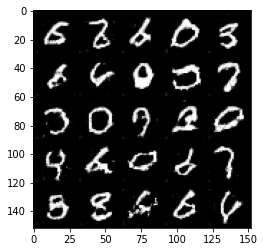

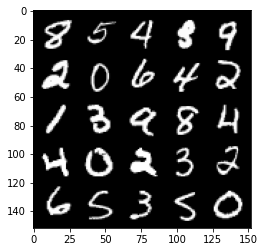

Step 10000: Generator loss: 0.762622428715229, Discriminator loss: 0.6821679710149755


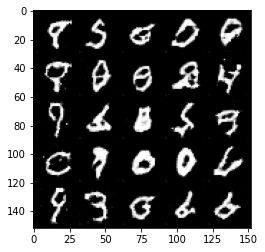

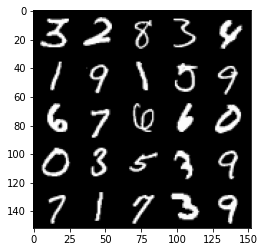

Step 10500: Generator loss: 0.7584124138951301, Discriminator loss: 0.6851125699281687


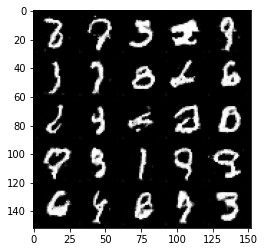

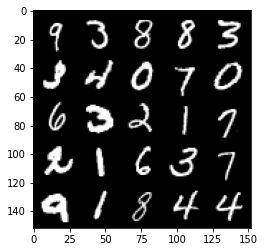

Step 11000: Generator loss: 0.7517850983738903, Discriminator loss: 0.6883082406520844


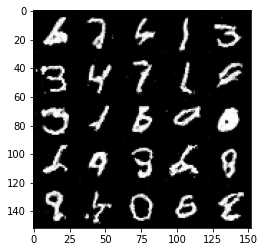

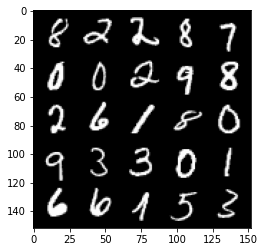

Step 11500: Generator loss: 0.7350376513600353, Discriminator loss: 0.6953269597291949


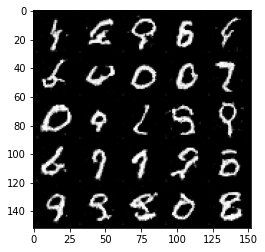

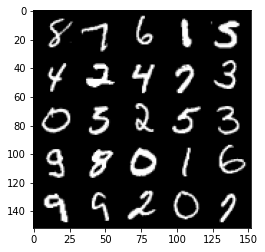

Step 12000: Generator loss: 0.7378221927881241, Discriminator loss: 0.6937241975069045


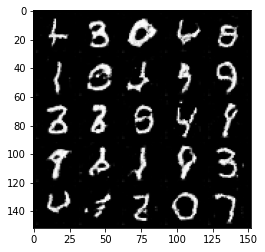

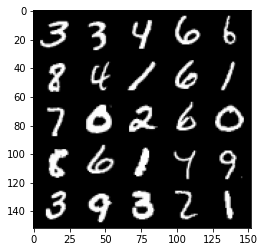

Step 12500: Generator loss: 0.7338952848911285, Discriminator loss: 0.6940703431367873


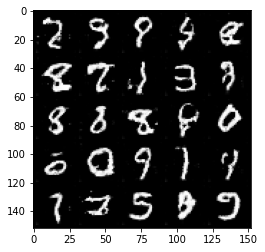

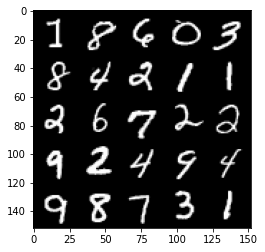

Step 13000: Generator loss: 0.7349051457047464, Discriminator loss: 0.6969410581588746


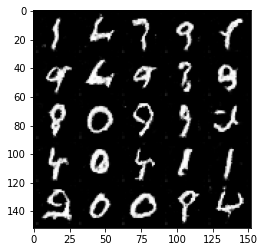

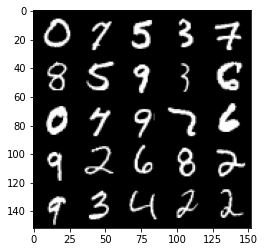

Step 13500: Generator loss: 0.7320506799221034, Discriminator loss: 0.6982848374843598


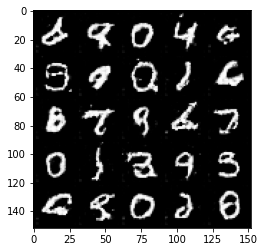

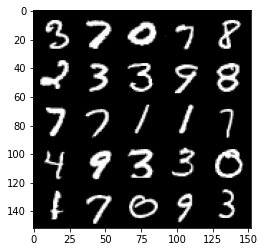

Step 14000: Generator loss: 0.7254444883465767, Discriminator loss: 0.6985095108747481


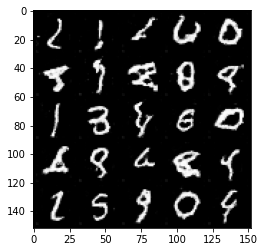

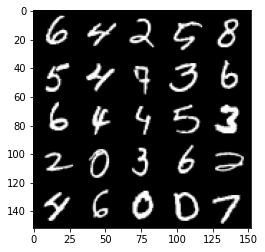

Step 14500: Generator loss: 0.7229119684100151, Discriminator loss: 0.6986312773227688


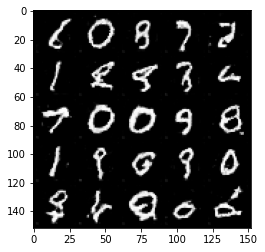

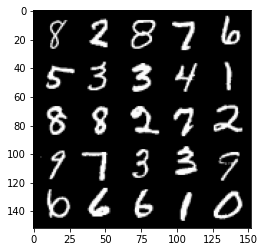

Step 15000: Generator loss: 0.7171076836585993, Discriminator loss: 0.7012425682544708


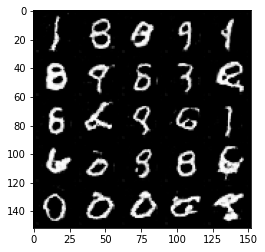

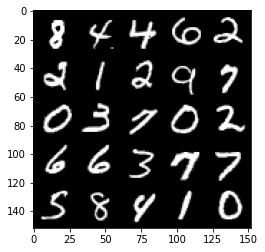

Step 15500: Generator loss: 0.7136444713473326, Discriminator loss: 0.7012356505393984


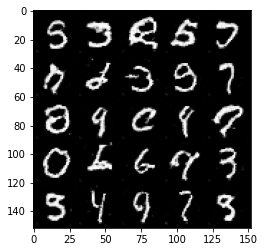

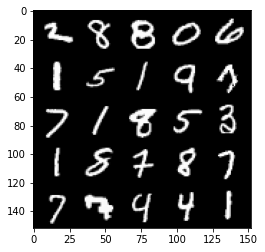

Step 16000: Generator loss: 0.7153769941329959, Discriminator loss: 0.6999923219680779


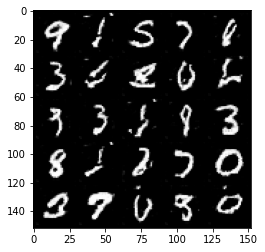

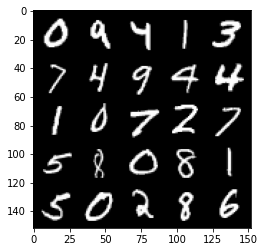

Step 16500: Generator loss: 0.7122353850007058, Discriminator loss: 0.6988342554569249


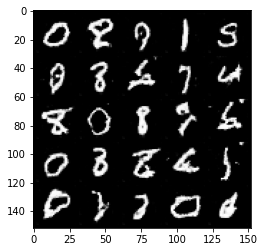

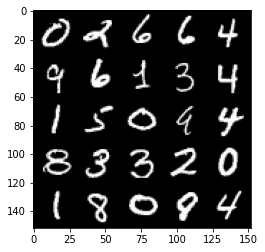

Step 17000: Generator loss: 0.7109384446144112, Discriminator loss: 0.7007857893705371


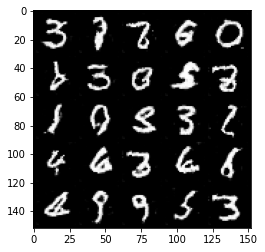

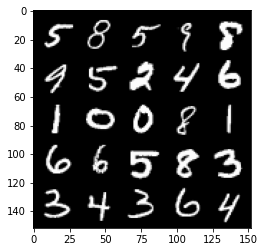

Step 17500: Generator loss: 0.7062700008749963, Discriminator loss: 0.7011968760490418


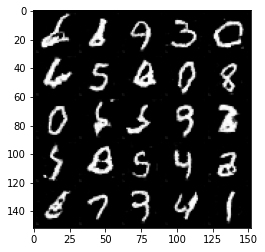

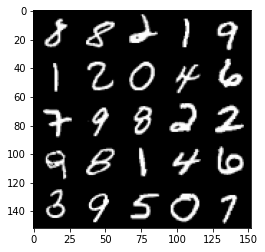

Step 18000: Generator loss: 0.7060577405095103, Discriminator loss: 0.6999974143505092


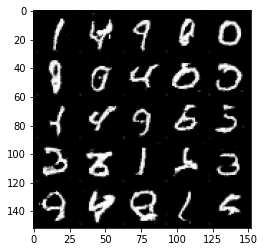

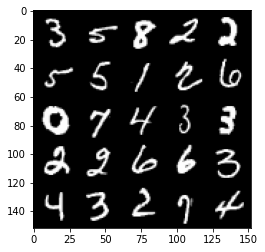

Step 18500: Generator loss: 0.7053323466777798, Discriminator loss: 0.6989667377471926


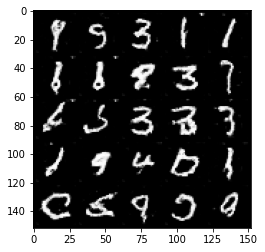

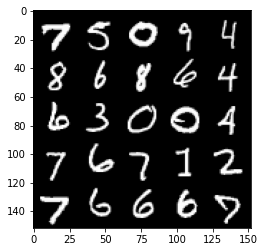

Step 19000: Generator loss: 0.7035403701066976, Discriminator loss: 0.7001592550277704


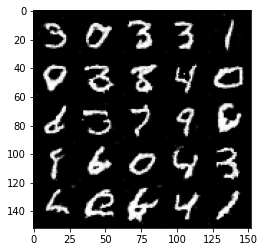

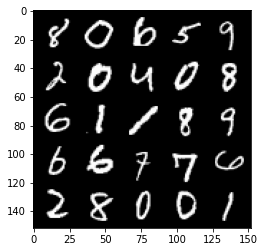

Step 19500: Generator loss: 0.705127501785755, Discriminator loss: 0.7000085344314572


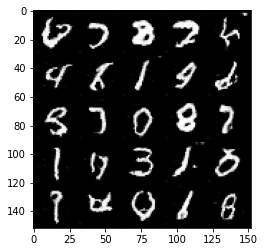

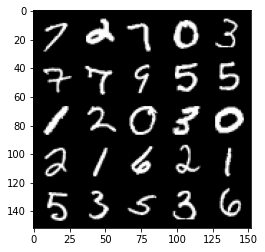

Step 20000: Generator loss: 0.7050747457742691, Discriminator loss: 0.6993821724653237


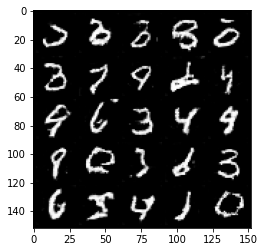

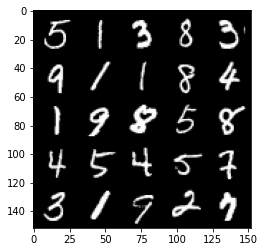

Step 20500: Generator loss: 0.7052757376432428, Discriminator loss: 0.6990570330619811


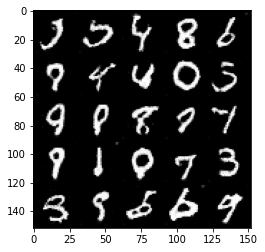

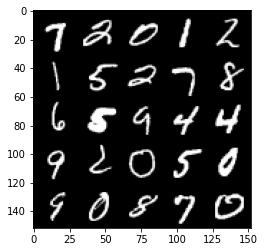

Step 21000: Generator loss: 0.69884450352192, Discriminator loss: 0.7016138920784


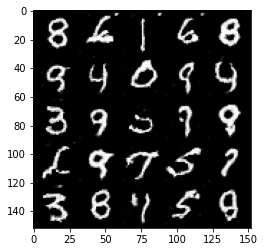

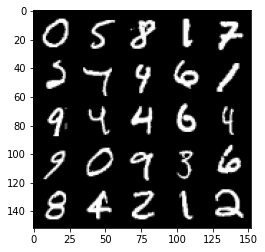

Step 21500: Generator loss: 0.7025311218500134, Discriminator loss: 0.6979208605289463


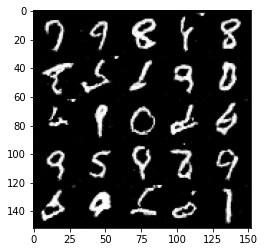

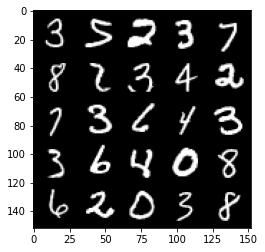

Step 22000: Generator loss: 0.7027077362537386, Discriminator loss: 0.6983223383426664


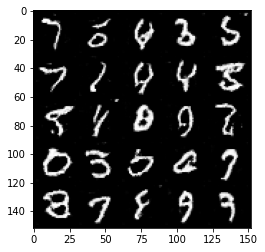

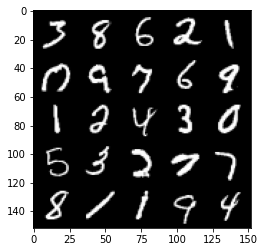

Step 22500: Generator loss: 0.7012185559868809, Discriminator loss: 0.6975123426914217


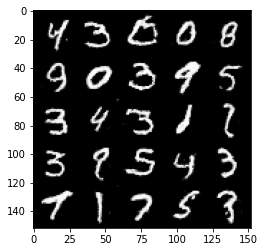

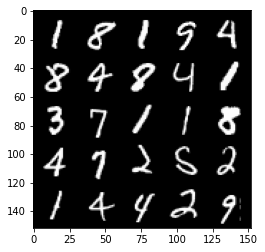

Step 23000: Generator loss: 0.6981406298875807, Discriminator loss: 0.6988008731603618


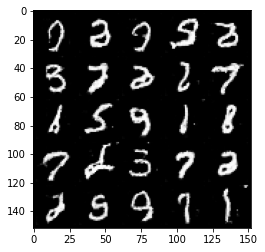

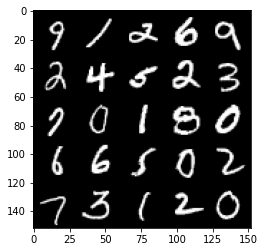

In [6]:
n_epochs = 50
step_i = 0
mean_gen_loss = 0
mean_disc_loss = 0

for epoch in range(n_epochs):
  # Dataloader returns the batches
  for real_img, _ in tqdm(dataloader):
    batch_size_i = len(real_img)
    real_img = real_img.to(device)

    ## updating the discriminator
    disc_opt.zero_grad()
    noise_vec = get_noise(batch_size_i, noise_dim, device)
    fake_img = gen(noise_vec)
    fake_pred = disc(fake_img.detach())
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
    real_pred = disc(real_img)
    real_loss = criterion(real_pred, torch.ones_like(real_pred))
    disc_loss = (fake_loss + real_loss) / 2

    # keeping track of the average discriminator loss
    mean_disc_loss += disc_loss.item() / viz_step
    # updating the gradients
    disc_loss.backward(retain_graph=True)
    # updating the optimizer
    disc_opt.step()

    ## updating the generator
    gen_opt.zero_grad()
    noise_vec_2 = get_noise(batch_size_i, noise_dim, device)
    fake_img_2 = gen(noise_vec_2)
    fake_pred = disc(fake_img_2)
    gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))
    gen_loss.backward()
    gen_opt.step()

    # keeping track of the average generator loss
    mean_gen_loss += gen_loss.item() / viz_step

    ## visualization
    if step_i % viz_step == 0 and step_i > 0:
      print(f"Step {step_i}: Generator loss: {mean_gen_loss}, Discriminator loss: {mean_disc_loss}")
      tensor_image_viz(fake_img)
      tensor_image_viz(real_img)
      mean_gen_loss = 0
      mean_disc_loss = 0
    step_i += 1

